In [1]:
import os
from google.colab import drive
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
!pip install datasets
import datasets
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split
!pip install transformers
import logging
import os
import sys
import random
import json
from dataclasses import dataclass, field
from typing import Optional
import datasets
from datasets import load_dataset
from sklearn.metrics import f1_score, classification_report, mean_absolute_error, accuracy_score, confusion_matrix
import glob
import shutil
import transformers
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    Trainer,
    HfArgumentParser,
    TrainingArguments,
    default_data_collator,
    set_seed,
    EarlyStoppingCallback,
    pipeline
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 95.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 78.8 MB/s eta 0:00:00


In [2]:
#Mount Goodle colab with Google Drive
drive.mount('/content/drive',force_remount=True) 
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive


In [3]:
# Name of the zipped file
zip_name = "archive.zip"

#List of the files inside the zip
df_list=[]

# Open the zipped file
# Loop through each file in the zipped file
# Read the JSON file into a pandas DataFrame
# Append them into a list
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    for file_name in zip_ref.namelist():        
            with zip_ref.open(file_name) as file:
                df = pd.read_json(file)
                df_list.append(df)

# Concatanate all the DataFrames into one            
data=pd.concat(df_list)

# Delete extra DataFrames
del df_list
del df

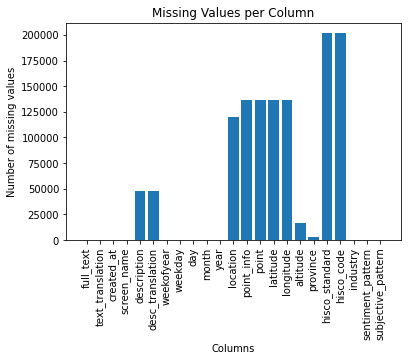

In [4]:
# Count the number of missing values in each column
missing_values = data.isna().sum()

# Create a bar chart showing the number of missing values in each column
plt.bar(missing_values.index, missing_values.values)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Number of missing values')
plt.title('Missing Values per Column')
plt.show()

#Delete rows without text
data = data.dropna(subset=['full_text'])

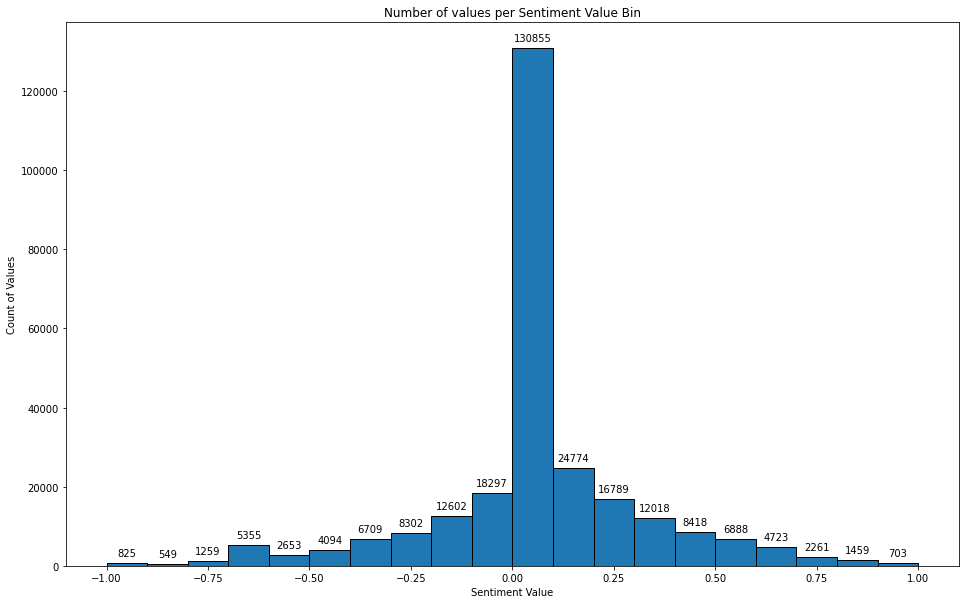

In [5]:
# Create bins from -1 to 1 with 0.1 width
bins = np.arange(-1, 1.1, 0.1)

# Create a histogram with the different values of sentiment
fig, ax = plt.subplots(figsize=(16, 10))
ax.hist(data.sentiment_pattern, bins=bins, edgecolor='black')

# Put count numbers above bars
for rect in ax.patches:
    height = rect.get_height()
    ax.annotate(f'{int(height)}', xy=(rect.get_x()+rect.get_width()/2, height), 
                xytext=(0, 5), textcoords='offset points', ha='center', va='bottom') 

# Show the plot
plt.xlabel('Sentiment Value')
plt.ylabel('Count of Values')
plt.title('Number of values per Sentiment Value Bin')
plt.show()

In [6]:
# Keep only the relevant columns and drop na
data_final=data[['text_translation','sentiment_pattern']]
data_final=data_final.reset_index()
data_final=data_final.dropna()

# Based on the sentiment value destribution, create integer hard labels:
# Positive (2): (0.15-1)
# Neutral (1): [0-0.15]
# Negative (0): (-1-0)
data_final['sentiment_pattern'] = np.where(data_final['sentiment_pattern'] > 0.15, 2, data_final['sentiment_pattern'])
data_final['sentiment_pattern'] = np.where(data_final['sentiment_pattern'].between(0,0.15), 1, data_final['sentiment_pattern'])
data_final['sentiment_pattern'] = np.where(data_final['sentiment_pattern'] < 0, 0, data_final['sentiment_pattern'])
data_final['sentiment_pattern']=data_final['sentiment_pattern'].astype('int')

# Split data into training, validation,test sets
train, test = train_test_split(data_final, test_size=0.2, random_state=25)
train, val = train_test_split(train, test_size=0.2, random_state=25)

# Transform it into Hugging Face Dataset types for easier manipulation
train=Dataset.from_pandas(train,split='train')
val=Dataset.from_pandas(val,split='validation')
test=Dataset.from_pandas(test,split='test')

# Labels with integer values
labels2ids = {'negative':0,'neutral':1,'positive':2}

# Keep only a slice of dataset for practical issues
train = train.select(range(2000))
val = val.select(range(400))
test = test.select(range(400))

<ipython-input-6-875a8991e4fd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['sentiment_pattern'] = np.where(data_final['sentiment_pattern'] > 0.15, 2, data_final['sentiment_pattern'])
<ipython-input-6-875a8991e4fd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['sentiment_pattern'] = np.where(data_final['sentiment_pattern'].between(0,0.15), 1, data_final['sentiment_pattern'])
<ipython-input-6-875a8991e4fd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

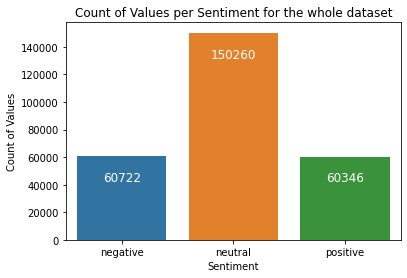

In [7]:
# Create count plot
ax = sns.countplot(x="sentiment_pattern", data=data_final)

# Add counts for each bar
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=12)

# Show plot
ax.set_xticklabels(['negative', 'neutral', 'positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count of Values')
plt.title('Count of Values per Sentiment for the whole dataset')
plt.show()

In [8]:
# Delete extra DataFrame
del data_final

In [9]:
# Define the tokenizer
tokenizer = AutoTokenizer.from_pretrained("roberta-base", do_lower_case=True, use_fast=True,)
tokenizer.model_max_length = 512

In [10]:
# Load configuration for model
config = AutoConfig.from_pretrained('roberta-base', num_labels=3, label2id=labels2ids, id2label={v: k for k, v in labels2ids.items()},)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(
        "roberta-base",config=config   )

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [11]:
# Define the preprocess function for tokenization
def preprocess_function(examples):
        batch = tokenizer( examples["text_translation"], padding='max_length', max_length=512, truncation=True,)
        batch['label'] = examples['sentiment_pattern']
        return batch

In [12]:
# Apply the preprocess funtion
train_dataset = train.map( preprocess_function, batched=True, load_from_cache_file=False)

eval_dataset = val.map( preprocess_function, batched=True, load_from_cache_file=False)

predict_dataset = test.map( preprocess_function, batched=True,  load_from_cache_file=False)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

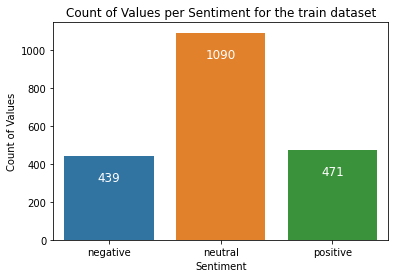

In [13]:
# Create count plot
ax = sns.countplot(x="label", data=pd.DataFrame(train_dataset))

# Add counts for each bar
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=12)

# Show plot
ax.set_xticklabels(['negative', 'neutral', 'positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count of Values')
plt.title('Count of Values per Sentiment for the train dataset')
plt.show()

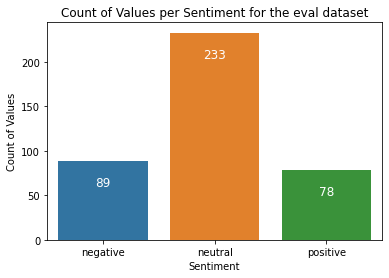

In [14]:
# Create count plot
ax = sns.countplot(x="label", data=pd.DataFrame(eval_dataset))

# Add counts for each bar
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=12)

# Show plot
ax.set_xticklabels(['negative', 'neutral', 'positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count of Values')
plt.title('Count of Values per Sentiment for the eval dataset')
plt.show()

In [15]:
# Define accuracy, macro and micro F1 metrics for model evaluation
def compute_metrics(p: EvalPrediction):
        logits = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
        preds = np.argmax(logits, axis=1)
        macro_f1 = f1_score(y_true=p.label_ids, y_pred=preds, average='macro', zero_division=0)
        micro_f1 = f1_score(y_true=p.label_ids, y_pred=preds, average='micro', zero_division=0)
        accuracy = accuracy_score(y_true=p.label_ids, y_pred=preds)
        return {'macro_f1': macro_f1, 'micro_f1': micro_f1, 'accuracy': accuracy}

In [16]:
# Initialize training arguments
args = TrainingArguments(
   f"training_with_callbacks",
   evaluation_strategy= 'epoch',
   save_strategy= 'epoch',
   eval_steps = 100, # Evaluation and Save happens every 100 steps
   save_total_limit = 2, # Only last 2 models are saved. Older ones are deleted.
   learning_rate=2e-5,
   num_train_epochs=5,
   push_to_hub=False,
   metric_for_best_model = 'macro_f1',
   greater_is_better=True,
   weight_decay=0.01,
   load_best_model_at_end=True)

# Initialize Trainer with early stopping
data_collator = default_data_collator
trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

In [17]:
# Train the model
train_result = trainer.train(resume_from_checkpoint=None)

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text_translation, sentiment_pattern, __index_level_0__, index. If text_translation, sentiment_pattern, __index_level_0__, index are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 2000
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1250
  Number of trainable parameters = 124647939


Epoch,Training Loss,Validation Loss,Macro F1,Micro F1,Accuracy
1,No log,0.934207,0.245392,0.582500,0.582500
2,0.993400,0.977235,0.361184,0.560000,0.560000
3,0.993400,0.927374,0.411334,0.582500,0.582500
4,0.799600,0.958536,0.524806,0.610000,0.610000
5,0.799600,1.067339,0.517037,0.570000,0.570000


The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text_translation, sentiment_pattern, __index_level_0__, index. If text_translation, sentiment_pattern, __index_level_0__, index are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 8
Saving model checkpoint to training_with_callbacks/checkpoint-250
Configuration saved in training_with_callbacks/checkpoint-250/config.json
Model weights saved in training_with_callbacks/checkpoint-250/pytorch_model.bin
tokenizer config file saved in training_with_callbacks/checkpoint-250/tokenizer_config.json
Special tokens file saved in training_with_callbacks/checkpoint-250/special_tokens_map.json
Deleting older checkpoint [training_with_callbacks/checkpoint-1250] due to args.save_total_limit
The following columns in the evaluation set don't ha

In [18]:
# Train metrics and model save
metrics = train_result.metrics
metrics["train_samples"] = len(train_dataset)
trainer.save_model()
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

Saving model checkpoint to training_with_callbacks
Configuration saved in training_with_callbacks/config.json
Model weights saved in training_with_callbacks/pytorch_model.bin
tokenizer config file saved in training_with_callbacks/tokenizer_config.json
Special tokens file saved in training_with_callbacks/special_tokens_map.json


***** train metrics *****
  epoch                    =        5.0
  total_flos               =  2450434GF
  train_loss               =     0.8318
  train_runtime            = 0:17:21.97
  train_samples            =       2000
  train_samples_per_second =      9.597
  train_steps_per_second   =        1.2


In [19]:
# Eval metrics
metrics = trainer.evaluate(eval_dataset=eval_dataset)
max_eval_samples =  len(eval_dataset)
metrics["eval_samples"] = max_eval_samples
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

The following columns in the evaluation set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text_translation, sentiment_pattern, __index_level_0__, index. If text_translation, sentiment_pattern, __index_level_0__, index are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 400
  Batch size = 8


***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =       0.61
  eval_loss               =     0.9585
  eval_macro_f1           =     0.5248
  eval_micro_f1           =       0.61
  eval_runtime            = 0:00:11.93
  eval_samples            =        400
  eval_samples_per_second =     33.528
  eval_steps_per_second   =      4.191


In [20]:
# Predict metrics and Classification Report
predictions, labels, metrics = trainer.predict(predict_dataset, metric_key_prefix="predict")
max_predict_samples = len(predict_dataset)
metrics["predict_samples"] = len(predict_dataset)
predict_report = classification_report(y_true=labels, y_pred=np.argmax(predictions, axis=-1),
                                               labels=range(3),
                                               target_names=list(labels2ids.keys()))
print(predict_report)

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text_translation, sentiment_pattern, __index_level_0__, index. If text_translation, sentiment_pattern, __index_level_0__, index are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 400
  Batch size = 8


              precision    recall  f1-score   support

    negative       0.55      0.30      0.39        93
     neutral       0.70      0.82      0.76       228
    positive       0.50      0.51      0.50        79

    accuracy                           0.64       400
   macro avg       0.58      0.54      0.55       400
weighted avg       0.62      0.64      0.62       400



In [21]:
# Classification report CSV
report_predict_file = os.path.join( f"predict_report.csv")
with open(report_predict_file, "w") as writer:
  writer.write(predict_report)

# Log metrics
trainer.log_metrics("predict", metrics)
trainer.save_metrics("predict", metrics)

# Prediction logits CSV
output_predict_file = os.path.join( "test_predictions.csv")
if trainer.is_world_process_zero():
            with open(output_predict_file, "w") as writer:
                for index, pred_list in enumerate(predictions):
                    pred_line = '\t'.join([f'{pred:.5f}' for pred in pred_list])
                    writer.write(f"{index}\t{pred_line}\n")

***** predict metrics *****
  predict_accuracy           =       0.64
  predict_loss               =     0.9229
  predict_macro_f1           =     0.5495
  predict_micro_f1           =       0.64
  predict_runtime            = 0:00:12.03
  predict_samples            =        400
  predict_samples_per_second =     33.235
  predict_steps_per_second   =      4.154


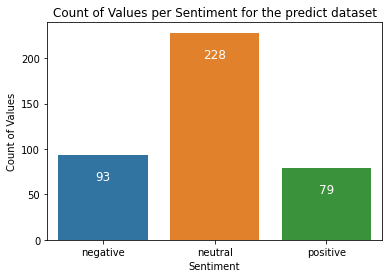

In [22]:
# Create count plot
ax = sns.countplot(x="label", data=pd.DataFrame(predict_dataset))

# Add counts for each bar
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=12)

# Show plot
ax.set_xticklabels(['negative', 'neutral', 'positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count of Values')
plt.title('Count of Values per Sentiment for the predict dataset')
plt.show()

In [23]:
y_pred=np.argmax(predictions, axis=-1)
len(y_pred)

400

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


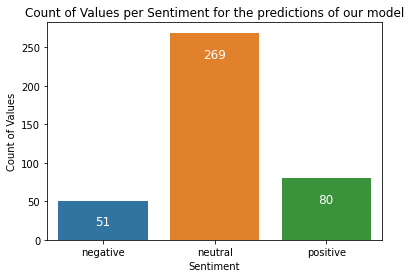

In [29]:
# Create count plot
ax = sns.countplot(y_pred)

# Add counts for each bar
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=12)

# Show plot
ax.set_xticklabels(['negative', 'neutral', 'positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count of Values')
plt.title('Count of Values per Sentiment for the predictions of our model')
plt.show()

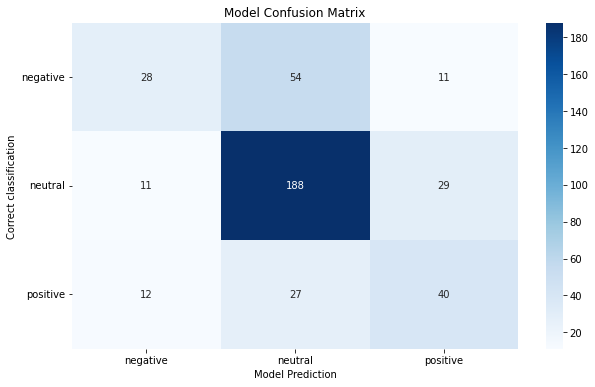

In [35]:
mat_aug = confusion_matrix(labels, y_pred)
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat_aug, annot=True, fmt='g', cmap = 'Blues')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('Model Confusion Matrix')
ax.xaxis.set_ticklabels(['negative', 'neutral', 'positive'])
ax.yaxis.set_ticklabels(['negative', 'neutral', 'positive'])
plt.yticks(rotation=0)
plt.show()